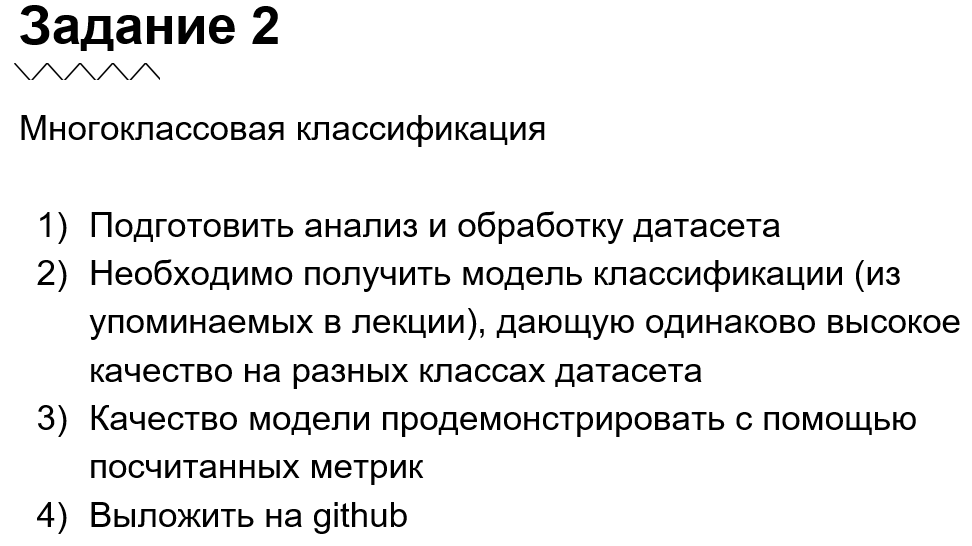

## Подготовка текста

In [1]:
!pip install nltk
!pip install tokenizers
!pip install pymystem3

In [2]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import torch

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

from pymystem3 import Mystem
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.preprocessing import LabelEncoder


In [3]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/GlowByte/dataset.xlsx")

In [6]:
df.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


In [7]:
df.to_csv("dataset.csv", index = False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53198 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       53198 non-null  int64 
 1   text      53198 non-null  object
 2   category  53198 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


### Количество новостей по каждой категории

In [9]:
class_counts = df.iloc[:, -1].value_counts()

for cls, count in class_counts.items():
    print(f"{cls}: {count}")

athletics: 4782
volleyball: 4683
tennis: 4584
boardgames: 4551
winter_sport: 4536
motosport: 4528
esport: 4509
basketball: 4329
football: 4262
martial_arts: 4259
extreme: 3172
autosport: 3152
hockey: 1851


In [10]:
df.describe()

,oid
count,5.319800e+04
mean,5.070402e+08
std,2.845804e+08
min,1.659400e+04
25%,2.685499e+08
50%,5.117385e+08
75%,7.489505e+08
max,9.997113e+08


### Балансировка классов

Первым делом удаление дубликатов

In [11]:
duplicates = df[df.duplicated(subset=['text'], keep=False)]
df = df.drop_duplicates(subset=['text'], keep='first')

In [12]:
removed_duplicates = duplicates[~duplicates.index.isin(df.index)].reset_index()
paired_duplicates_with_index = removed_duplicates.merge(df.reset_index(), on='text', how='inner', suffixes=('_removed', '_original'))
paired_duplicates_with_index[['index_removed', 'text', 'index_original']]


,index_removed,text,index_original
0,51,Как играли в баскетбол раньше. . У кого до сих...,49
1,54,До свидания щит 33 Дмитрий Михеев во всей крас...,48
2,519,В Шерегеше 1 июля откроется один из самых боль...,448
3,641,За кроссовками в Баскетбольный магазин Ghetto ...,640
4,642,За кроссовками в Баскетбольный магазин Ghetto ...,640
...,...,...,...
5220,53165,В группе один Администратор Добавляй в друзья ...,17559
5221,53174,news tokenoid Sttokenoid Hortokenoid В трейлер...,3795
5222,53175,Счастливчики которые уносят Кассадина 33 За пр...,30407
5223,53179,В продаже октябрьский Мир фантастики В этом но...,9817


In [13]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 47973 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       47973 non-null  int64 
 1   text      47973 non-null  object
 2   category  47973 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


(47973, 3)

Мы удалили явные дубликаты, но, возможно, есть те, которые имеют одинаковый текст новости, но при этом различные знаки препинания/регистр

### Предобработка текста

**Удаление:**
1. знаки препинания
2. числа
3. слова, которые встречаются в каждом классе
4. tokenoid - мусор
5. лишние пробелы
6. лемматизация
7. повторы в одной новости
8. стоп слова и слова длины < 1

In [14]:
stop = set(stopwords.words('russian'))
with open('/content/drive/MyDrive/GlowByte/stopwords-ru.txt', 'r', encoding='utf-8') as file:
    additional_stop_words = set(file.read().splitlines())


In [15]:
def preprocess_text(text):
    pattern_punct = r'[^\w\s]'
    text = re.sub(pattern_punct, '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    pattern_digits = r'[+-]?\d+(\.\d+)?'
    text = re.sub(pattern_digits, '', text)
    pattern_tok = r'\b\w*tokenoid\w*\b'
    pattern_common_words = r'\bэто\b|\bгод\b|\bдень\b|\bхороший\b|\bкоторый\b'
    text = re.sub(pattern_tok, '', text)
    text = re.sub(pattern_common_words, '', text)
    return text

df['preprocess_text'] = df['text'].apply(preprocess_text)

In [16]:
df

,oid,text,category,preprocess_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочно сообщество продается за р за покупкой п...
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побудет здесь борьбавпрямомэфире
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюлей от мунсунга борьбавпрямомэфире
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,не знаю как вам но мне стилистика нравится пус...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншоты из новой главы тэхунчика показали и ...
...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,битная буря снова накрыла пикселями автомобил...
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,ира сидоркова объясняет как сказалась на ее ма...
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,я ракетка мира хорват марин чилич обыграл исп...
53196,776944963,Стал известен календарь мужской сборной России...,volleyball,стал известен календарь мужской сборной россии...


In [17]:
# удаление стоп слов
all_stop_words = stop.union(additional_stop_words)
df['preprocess_text'] = df['preprocess_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in all_stop_words and len(word) > 1]))

In [18]:
df.head()

,oid,text,category,preprocess_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочно сообщество продается покупкой пишите лс...
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побудет борьбавпрямомэфире
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюлей мунсунга борьбавпрямомэфире
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знаю стилистика нравится пускай странная борьб...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншоты новой главы тэхунчика показали хобина


### Объединение терминов

Я заметила, что есть термины, которые часто встречаются и объединила их

In [19]:
def join_english_terms(text):
    terms = {
        "cs go": "csgo",
        "ai": "ai",
        "ml": "ml",
        "nft": "nft",
        "block chain": "blockchain"
    }
    for term, replacement in terms.items():
        text = re.sub(r'\b{}\b'.format(term), replacement, text, flags=re.IGNORECASE)
    return text

In [20]:
df['preprocess_text'] = df['preprocess_text'].apply(join_english_terms)

In [21]:
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [22]:
def lemmatize_text(text):
    lemmas = mystem.lemmatize(text)
    lemmas = [lemma for lemma in lemmas if lemma.strip() not in stop and lemma.strip()]
    return ' '.join(lemmas)

In [23]:
df['preprocess_text'] = df['preprocess_text'].apply(lemmatize_text)

In [24]:
df['preprocess_text'] = df['preprocess_text'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

Снова удаляю дубликаты новостей, если вдруг они появились после предварительной обработки

Как итог: дубликатов не оказалось

In [25]:
duplicates = df[df.duplicated(subset=['preprocess_text'], keep=False)]
df = df.drop_duplicates(subset=['preprocess_text'], keep='first')
df.shape

(47504, 4)

In [26]:
def count_words(text):
    return len(text.split())

df['word_count'] = df['preprocess_text'].apply(count_words)

total_word_count = df['word_count'].sum()
total_word_count

<ipython-input-26-02f733fafa58>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['preprocess_text'].apply(count_words)


1362444

In [27]:
df['len_text'] = df['preprocess_text'].apply(len)

<ipython-input-27-04cbb2819f3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_text'] = df['preprocess_text'].apply(len)


In [28]:
df

,oid,text,category,preprocess_text,word_count,len_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочный сообщество продаваться покупка писать ...,7,57
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побыть борьбавпрямомэфир,3,30
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюли мунсунг борьбавпрямомэфир,4,41
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знать стилистика нравиться пускай странный бор...,6,60
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншот новый глава тэхунчик показывать хобин,6,46
...,...,...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,битный буря накрывать пиксел автомобиль нуждат...,27,221
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,ира сидорков объяснять сказываться машина резу...,51,380
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,ракетка хорват марина чилич обыгрывать испанец...,24,176
53196,776944963,Стал известен календарь мужской сборной России...,volleyball,известный календарь мужской сборная россия роз...,34,264


График, демонстрирующий длины новостей

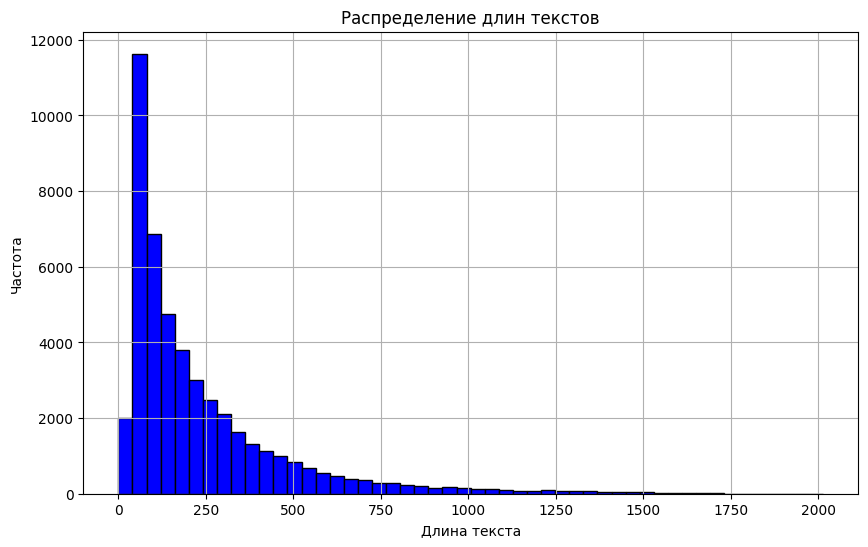

count    47504.000000
mean       236.992064
std        248.397830
min          0.000000
25%         73.000000
50%        148.000000
75%        303.000000
max       2013.000000
Name: len_text, dtype: float64

In [29]:
length_stats = df['len_text'].describe()

plt.figure(figsize=(10, 6))
plt.hist(df['len_text'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

length_stats

In [30]:
df['oid'].nunique()

5971

## Объединение новостей одного oid

Объединяла тексты новостей одинакового id по определеному порогу для уменьшения датасета.

```thresholds``` - порог длины текста, который я подбирала, чтобы количество новостей по категории было +- одинаковое

Первоначально сделала один порог и обучала на таком датасете, но после преобразования порога результаты получились чуть лучше



In [31]:
thresholds = {
    'athletics': 130, 'winter_sport': 130, 'motosport': 110,
    'martial_arts': 100, 'volleyball': 100, 'boardgames': 100,
    'autosport': 85, 'tennis': 90, 'football': 80,
    'basketball': 75, 'extreme': 65,
    'esport': 55, 'hockey': 25
}

def combine_texts(df, thresholds):
    combined_texts = []
    oids = df['oid'].unique()

    for oid in oids:
        category = df[df['oid'] == oid]['category'].values[0]
        threshold = thresholds.get(category, 120)
        oid_texts = df[df['oid'] == oid]['preprocess_text'].tolist()
        combined_text = ''

        for text in oid_texts:
            if len(combined_text.split()) + len(text.split()) <= threshold:
                combined_text = combined_text + ' ' + text
            else:
                if combined_text:
                    combined_texts.append({
                        'oid': oid,
                        'category': category,
                        'preprocess_text': combined_text.strip()
                    })
                combined_text = text

        if combined_text:
            combined_texts.append({
                'oid': oid,
                'category': category,
                'preprocess_text': combined_text.strip()
            })

    return pd.DataFrame(combined_texts)

In [32]:
df_final = combine_texts(df, thresholds)

In [33]:
df_final

,oid,category,preprocess_text
0,749208109,esport,спочный сообщество продаваться покупка писать ...
1,452466036,martial_arts,естественный восстановление тяжелый тренировка...
2,452466036,martial_arts,владимир путин ислам махачев звонить хотеть по...
3,452466036,martial_arts,абдулманап нурмагомедов прошлый весна доводить...
4,452466036,martial_arts,джастин гэтжи уверенный бой чарльз оливейра аз...
...,...,...,...
20029,747121187,boardgames,гильдияразработчиковнастольныхигра грань полез...
20030,881882347,boardgames,привет грань дискуссия хотеть обсуждать интере...
20031,209435461,esport,аудио визуальный вкус красота нотка возбуждени...
20032,922932190,hockey,сборная россия сыграть финляндия финал олимпиа...


In [34]:
output_path = 'final_dataset.csv'
df_final.to_csv(output_path, index=False)

In [35]:
df_final['len_text'] = df_final['preprocess_text'].apply(len)

проверяла количество слов, чтобы удостовериться в том, что никакие новости не были потеряны

In [36]:
def count_words(text):
    return len(text.split())

df_final['word_count'] = df_final['preprocess_text'].apply(count_words)

total_word_count = df_final['word_count'].sum()
total_word_count

1362444

График длин новостей на новых данных

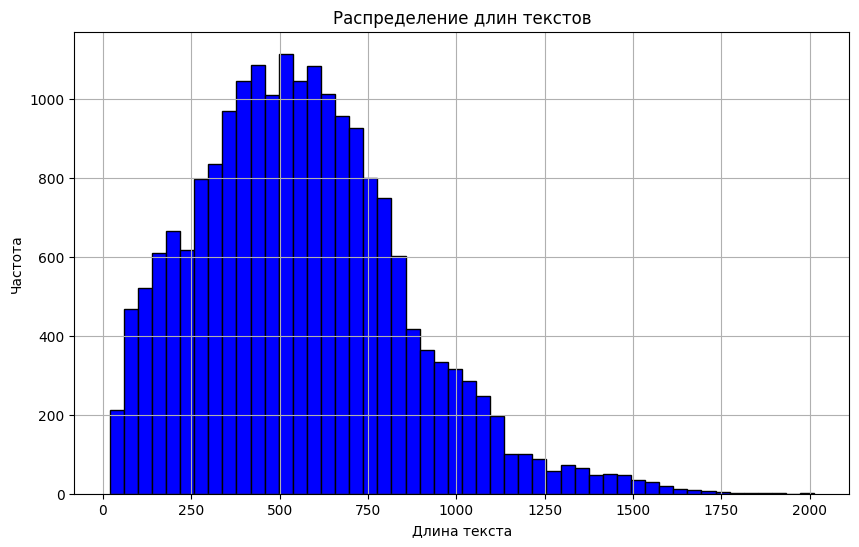

count    20034.000000
mean       563.319407
std        295.727053
min         19.000000
25%        350.000000
50%        540.000000
75%        739.000000
max       2013.000000
Name: len_text, dtype: float64

In [37]:
length_stats = df_final['len_text'].describe()

plt.figure(figsize=(10, 6))
plt.hist(df_final['len_text'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

length_stats

Можно заметить выброс справа -> удалю его

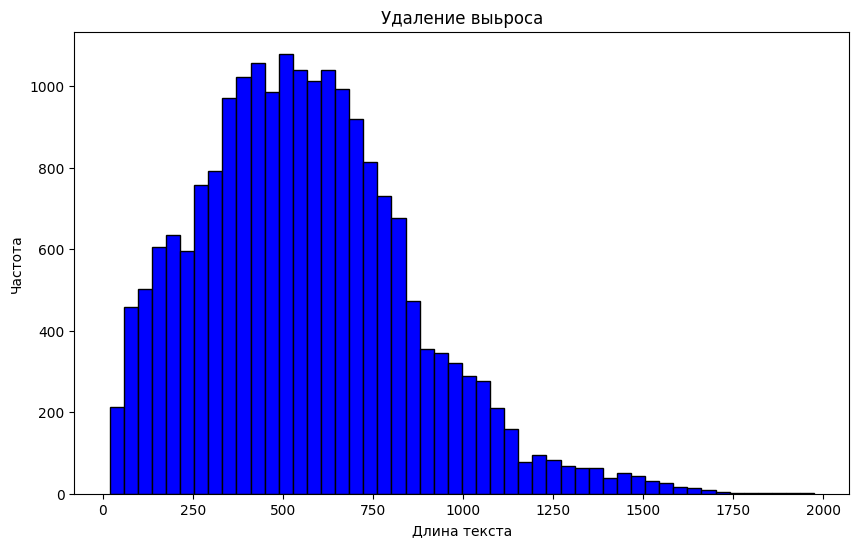

(         oid      category                                    preprocess_text  \
 0  749208109        esport  спочный сообщество продаваться покупка писать ...   
 1  452466036  martial_arts  естественный восстановление тяжелый тренировка...   
 2  452466036  martial_arts  владимир путин ислам махачев звонить хотеть по...   
 3  452466036  martial_arts  абдулманап нурмагомедов прошлый весна доводить...   
 4  452466036  martial_arts  джастин гэтжи уверенный бой чарльз оливейра аз...   
 
    len_text  word_count  
 0       414          47  
 1       687          85  
 2       541          65  
 3       834          98  
 4       274          34  ,
 (20033, 5))

In [38]:
threshold_length = 2000
df_final = df_final[df_final['len_text'] <= threshold_length]

plt.figure(figsize=(10, 6))
plt.hist(df_final['len_text'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Удаление выброса')
plt.show()

df_final.head(), df_final.shape

In [39]:
df_final = df_final.drop(columns = ['word_count'])

### Итоговое количество новостей по каждой категории

In [40]:
class_counts = df_final['category'].value_counts()

for cls, count in class_counts.items():
    print(f"{cls}: {count}")

tennis: 1585
volleyball: 1582
esport: 1570
martial_arts: 1567
athletics: 1555
basketball: 1534
football: 1533
extreme: 1531
boardgames: 1524
winter_sport: 1523
motosport: 1516
autosport: 1509
hockey: 1504


In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
X = df_final['preprocess_text']
y = df_final['category']


In [43]:
# кодирование категориального признака ДЛЯ ЛСТМ
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Разделение выборки на тестовую и обучающую

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (16026,)
Размер тестовой выборки: (4007,)


In [46]:
from transformers import AutoTokenizer, AutoModel

### Эмбеддинги RuBert

In [47]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(120138, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [49]:
def get_bert_embeddings_batch(texts, tokenizer, model, batch_size=32):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [50]:
X_train_embeddings = get_bert_embeddings_batch(X_train.tolist(), tokenizer, model)

In [51]:
X_test_embeddings = get_bert_embeddings_batch(X_test.tolist(), tokenizer, model)

In [52]:
embeddings_df = pd.DataFrame(X_train_embeddings)
embeddings_df['category'] = y_train

In [53]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,category
0,0.250897,0.411091,0.003784,0.578249,-0.331209,0.178643,-0.021291,0.429924,0.557824,-0.145694,...,-0.265162,-0.436724,0.108252,-0.470942,-0.185632,0.035413,-0.005496,0.240362,0.377569,11
1,0.281563,0.345114,0.002671,0.449795,-0.104769,0.410468,-0.013410,0.033038,0.127943,-0.422095,...,-0.025524,-0.626089,0.244421,-0.364970,0.085045,-0.026315,-0.035690,0.011730,0.246474,9
2,0.273265,0.250278,-0.045505,0.415630,-0.064991,0.652271,-0.008296,-0.130839,-0.081810,0.034758,...,-0.159067,-0.945326,0.589800,-0.297818,-0.123372,-0.053686,-0.030967,0.221812,0.147197,3
3,-0.142381,0.532136,-0.019117,0.540984,-0.542455,0.197936,-0.217027,-0.260062,0.300895,0.009156,...,-0.380043,-0.301847,0.000162,-0.714367,-0.329438,-0.138841,0.164481,0.257387,0.182542,0
4,0.147156,0.496425,0.062803,0.480911,-0.115367,0.417366,-0.222557,-0.202252,0.200599,-0.327868,...,-0.125850,-0.719256,0.450176,-0.349111,-0.004486,0.082280,0.005260,0.061892,-0.010793,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16021,0.277572,0.420022,0.087685,0.648673,-0.357856,0.431348,-0.029653,0.120935,0.172423,-0.340523,...,-0.126735,-0.485121,0.250243,-0.172507,0.004980,-0.102658,0.115573,0.096263,0.279868,12
16022,0.090221,0.415616,0.014897,0.463898,-0.323467,0.641673,-0.013758,0.047237,0.076435,-0.350548,...,-0.227589,-0.641761,0.194081,-0.312217,-0.059038,-0.190383,0.037490,0.090338,0.321055,0
16023,0.324135,0.355536,0.024496,0.450923,-0.274034,0.328217,0.051252,0.208943,0.149082,-0.283812,...,-0.039236,-0.733052,0.356858,-0.204168,-0.060708,-0.036758,0.041276,0.326434,0.246303,11
16024,0.160422,0.441354,0.046830,0.351258,-0.452070,0.564907,-0.198576,-0.143073,0.272145,-0.263342,...,-0.091790,-0.642841,0.129668,-0.626423,0.037657,-0.126483,0.113753,0.281913,0.392141,5


In [54]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [55]:
tsne = TSNE(n_components=2, random_state=42)
X_train_embeddings_2d = tsne.fit_transform(X_train_embeddings)

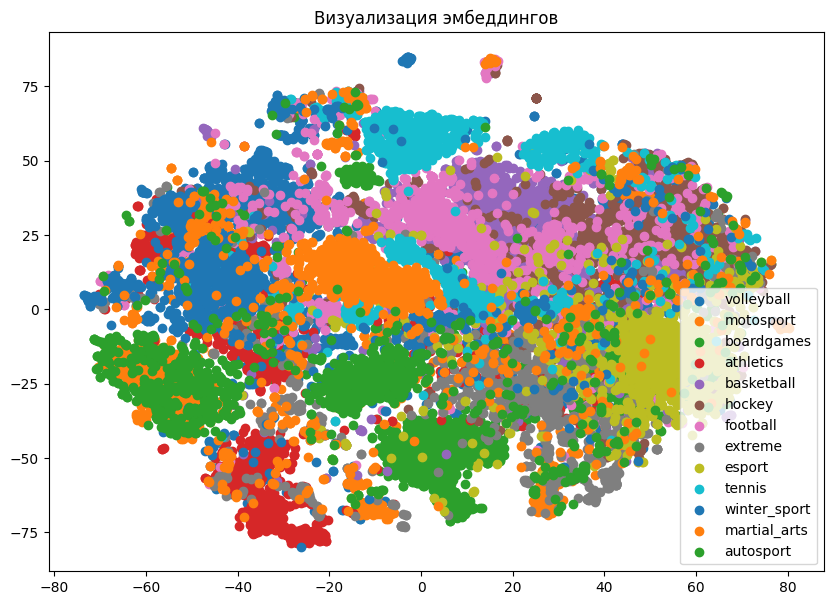

In [56]:
vis_df = pd.DataFrame(X_train_embeddings_2d, columns=['x', 'y'])
vis_df['category'] = label_encoder.inverse_transform(y_train)

plt.figure(figsize=(10, 7))
for category in vis_df['category'].unique():
    subset = vis_df[vis_df['category'] == category]
    plt.scatter(subset['x'], subset['y'], label=category)
plt.legend()
plt.title('Визуализация эмбеддингов')
plt.show()

результат неплохой, видно облака каждого класса

Балансировка Smote, которая создает синтетические образцы для меньшенств

In [57]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_embeddings, y_train)

### ЛСТМ

In [58]:

class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label


In [73]:
train_dataset = TextDataset(X_train_balanced, y_train_balanced)
test_dataset = TextDataset(X_test_embeddings, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [74]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.0):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Гиперпараметры

In [97]:
input_size = 768 # размер вектора для временного шага
hidden_size = 128 # количество нейронов
num_classes = len(label_encoder.classes_)
num_epochs = 25
num_layers = 2 # количество слоев
dropout = 0.5
learning_rate = 0.001

In [98]:
model = LSTMClassifier(input_size, hidden_size, num_classes, num_layers, dropout).to(device)

Функция потерь и оптимизатор

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Обучение модельки

In [100]:
best_loss = float('inf')
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            embeddings = embeddings.unsqueeze(1)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
            pbar.update(1)

    average_loss = total_loss / len(train_loader)
    loss_values.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    if average_loss < best_loss:
        best_loss = average_loss


Epoch 1/25: 100%|██████████| 516/516 [00:03<00:00, 164.49it/s, loss=1.29]


Epoch [1/25], Loss: 1.2907


Epoch 2/25: 100%|██████████| 516/516 [00:03<00:00, 142.53it/s, loss=0.795]


Epoch [2/25], Loss: 0.7954


Epoch 3/25: 100%|██████████| 516/516 [00:03<00:00, 132.97it/s, loss=0.701]


Epoch [3/25], Loss: 0.7011


Epoch 4/25: 100%|██████████| 516/516 [00:03<00:00, 163.18it/s, loss=0.644]


Epoch [4/25], Loss: 0.6435


Epoch 5/25: 100%|██████████| 516/516 [00:03<00:00, 156.48it/s, loss=0.607]


Epoch [5/25], Loss: 0.6066


Epoch 6/25: 100%|██████████| 516/516 [00:03<00:00, 164.52it/s, loss=0.597]


Epoch [6/25], Loss: 0.5971


Epoch 7/25: 100%|██████████| 516/516 [00:03<00:00, 144.81it/s, loss=0.554]


Epoch [7/25], Loss: 0.5539


Epoch 8/25: 100%|██████████| 516/516 [00:03<00:00, 136.22it/s, loss=0.54]


Epoch [8/25], Loss: 0.5404


Epoch 9/25: 100%|██████████| 516/516 [00:03<00:00, 158.01it/s, loss=0.527]


Epoch [9/25], Loss: 0.5273


Epoch 10/25: 100%|██████████| 516/516 [00:03<00:00, 167.22it/s, loss=0.514]


Epoch [10/25], Loss: 0.5138


Epoch 11/25: 100%|██████████| 516/516 [00:03<00:00, 157.93it/s, loss=0.489]


Epoch [11/25], Loss: 0.4890


Epoch 12/25: 100%|██████████| 516/516 [00:03<00:00, 148.10it/s, loss=0.487]


Epoch [12/25], Loss: 0.4872


Epoch 13/25: 100%|██████████| 516/516 [00:03<00:00, 138.09it/s, loss=0.478]


Epoch [13/25], Loss: 0.4775


Epoch 14/25: 100%|██████████| 516/516 [00:03<00:00, 155.23it/s, loss=0.467]


Epoch [14/25], Loss: 0.4666


Epoch 15/25: 100%|██████████| 516/516 [00:03<00:00, 166.35it/s, loss=0.456]


Epoch [15/25], Loss: 0.4563


Epoch 16/25: 100%|██████████| 516/516 [00:03<00:00, 160.04it/s, loss=0.445]


Epoch [16/25], Loss: 0.4445


Epoch 17/25: 100%|██████████| 516/516 [00:03<00:00, 146.82it/s, loss=0.438]


Epoch [17/25], Loss: 0.4380


Epoch 18/25: 100%|██████████| 516/516 [00:03<00:00, 135.44it/s, loss=0.423]


Epoch [18/25], Loss: 0.4233


Epoch 19/25: 100%|██████████| 516/516 [00:03<00:00, 154.56it/s, loss=0.417]


Epoch [19/25], Loss: 0.4169


Epoch 20/25: 100%|██████████| 516/516 [00:03<00:00, 156.47it/s, loss=0.399]


Epoch [20/25], Loss: 0.3989


Epoch 21/25: 100%|██████████| 516/516 [00:03<00:00, 163.61it/s, loss=0.392]


Epoch [21/25], Loss: 0.3922


Epoch 22/25: 100%|██████████| 516/516 [00:03<00:00, 148.29it/s, loss=0.393]


Epoch [22/25], Loss: 0.3933


Epoch 23/25: 100%|██████████| 516/516 [00:03<00:00, 138.41it/s, loss=0.385]


Epoch [23/25], Loss: 0.3848


Epoch 24/25: 100%|██████████| 516/516 [00:03<00:00, 149.66it/s, loss=0.37]


Epoch [24/25], Loss: 0.3699


Epoch 25/25: 100%|██████████| 516/516 [00:03<00:00, 155.58it/s, loss=0.362]

Epoch [25/25], Loss: 0.3616


Функция потерь уменьшается, что хорошо, так как улучшается точность модели. Также нет сильных рывков, значит модель стабильно обучается, тоже вроде неплохо

In [101]:
model.eval()
y_pred = []
y_true = []

In [102]:
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

## Метрики

In [103]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

   athletics       0.90      0.88      0.89       311
   autosport       0.91      0.80      0.85       302
  basketball       0.84      0.84      0.84       307
  boardgames       0.95      0.94      0.94       305
      esport       0.79      0.85      0.82       314
     extreme       0.67      0.85      0.75       306
    football       0.87      0.77      0.82       307
      hockey       0.80      0.81      0.81       301
martial_arts       0.89      0.86      0.87       313
   motosport       0.90      0.87      0.89       303
      tennis       0.92      0.97      0.95       317
  volleyball       0.88      0.84      0.86       316
winter_sport       0.88      0.87      0.88       305

    accuracy                           0.86      4007
   macro avg       0.86      0.86      0.86      4007
weighted avg       0.86      0.86      0.86      4007

Accuracy: 0.8579985026204143


Самая плохая производительность у extreme, но терпимая

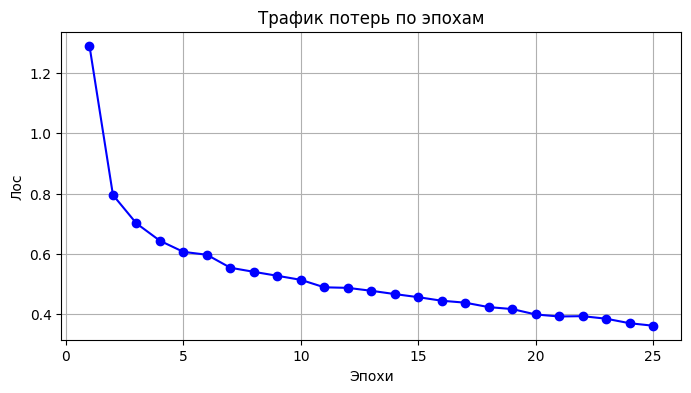

In [104]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Tрафик потерь по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Лос')
plt.grid(True)
plt.show()

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Матрица ошибок

Показывает кол-во верных и неверных предсказаний

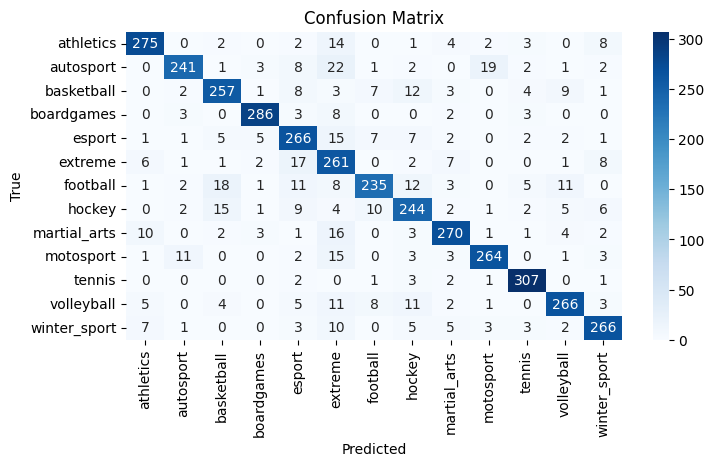

In [106]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Тут явно видно, что большинство классов предсказываются очень точно, а есть категории, в которых модель путается

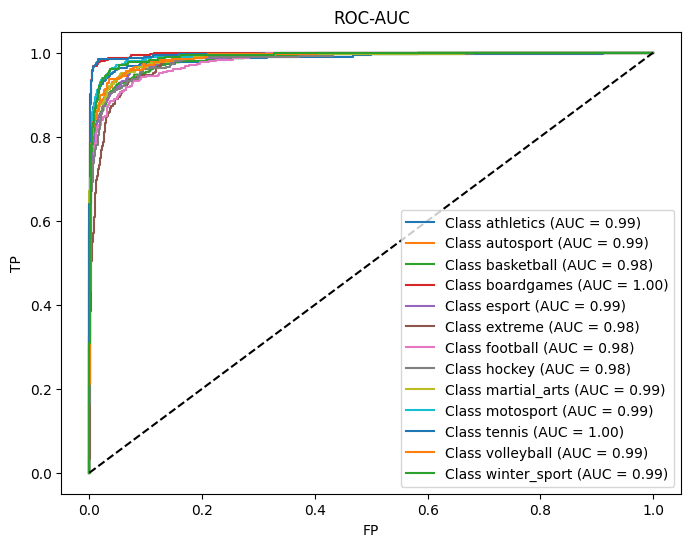

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

def get_predicted_probabilities(model, data_loader):
    model.eval()
    y_pred_prob = []
    y_true = []
    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings = embeddings.to(device)
            embeddings = embeddings.unsqueeze(1)
            outputs = model(embeddings)
            probabilities = torch.softmax(outputs, dim=1)
            y_pred_prob.extend(probabilities.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return np.array(y_pred_prob), np.array(y_true)

y_pred_prob, y_true = get_predicted_probabilities(model, test_loader)

fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(label_encoder.classes_)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true == i, y_pred_prob[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC-AUC')
plt.legend(loc='lower right')
plt.show()


В целом значение AUC высокие, у ```boardgames``` и ```tennis``` AUC = 1, то есть модель безошибочно определяет класс. Но какие-то классы имеют низкие AUC

## Логистическая регрессия

In [108]:
X_train_balanced_copy = np.copy(X_train_balanced)
y_train_balanced_copy = np.copy(y_train_balanced)
y_test_copy = np.copy(y_test)

In [109]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_balanced_copy, y_train_balanced_copy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [110]:
# Предсказание на тестовых данных
y_pred = log_reg_model.predict(X_test_embeddings)

In [111]:
print("Отчетик:")
print(classification_report(y_test_copy, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Отчетик:
              precision    recall  f1-score   support

   athletics       0.87      0.86      0.86       311
   autosport       0.84      0.84      0.84       302
  basketball       0.85      0.82      0.84       307
  boardgames       0.92      0.93      0.92       305
      esport       0.81      0.80      0.80       314
     extreme       0.70      0.75      0.72       306
    football       0.86      0.77      0.81       307
      hockey       0.81      0.81      0.81       301
martial_arts       0.85      0.84      0.85       313
   motosport       0.90      0.84      0.87       303
      tennis       0.93      0.96      0.94       317
  volleyball       0.84      0.87      0.85       316
winter_sport       0.82      0.89      0.85       305

    accuracy                           0.84      4007
   macro avg       0.85      0.84      0.84      4007
weighted avg       0.85      0.84      0.84      4007

Accuracy: 0.8445220863488895


Пыталась улучшить результат extreme, дополнительно обрабатывая его. Я удаляла часто повторяющиеся и редкие слова, чтоб было меньше шума, но результат оказался хуже, чем до обработки. 

Вывод: стараться лишний раз нет смысла, получается только хуже